# IPEO Project: Hurricane Damage Detection with Deep Learning

# 1. Setup

### 1.1 Install dependencies

In [8]:
!pip install -U -q torch torchvision matplotlib tqdm gdown 

  You can safely remove it manually.


### 1.2 Check if GPU is available

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import WeightedRandomSampler, DataLoader
from collections import Counter
from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from sklearn.metrics import accuracy_score, f1_score


print(torch.cuda.is_available())

False


## 2. Data Loading

Data is already downloaded and stored in local IPEO folder

In [ ]:
!unzip ipeo_hurricane_damage.zip -d ipeo_hurricane_for_students # Use only one time to unzip data, I now have it downloaded locally and on the cluster

### 2.1 Write a PyTorch Dataset class

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # somehow without this the data will not open
import glob


class Hurricane(Dataset):

    # mapping between folder names and indices
    LABEL_CLASSES = {
      'no_damage': 0,
      'damage': 1
    }


    def __init__(self, root_dir, transforms=None, split='train'):
        
        """
        root_dir: path to the extracted zip folder
        split: 'train', 'validation', or 'test'
        """

        self.transforms = transforms
        split_dir = os.path.join(root_dir, split)

        # prepare data
        self.data = []  # list of tuples of (image path, label class)

        for label_name, label_idx in self.LABEL_CLASSES.items():
            folder = os.path.join(split_dir, label_name)
            
            images = glob.glob(os.path.join(folder, "*.jpeg"))

            for img_path in images:
                self.data.append((img_path, label_idx))

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB") # convert to RGB, in some case pipeline may break otherwise

        # apply transformation
        if self.transforms is not None:
            img = self.transforms(img)

        # return image and label
        return img, label


Look at a random sample to understand what the pictures look like.

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact

dataset = Hurricane(
    root_dir="ipeo_hurricane_for_students", # Change this path if needed
    split="train",
    transforms=None
)

print(len(dataset))        # should be >0
print(dataset.data[:5])    # should show tuples (image_path, label)

@interact(idx=range(len(dataset)))
def plot_sample(idx=10000):
    img, label = dataset[idx]

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

19000
[('ipeo_hurricane_for_students/train/no_damage/-95.63417_29.854513.jpeg', 0), ('ipeo_hurricane_for_students/train/no_damage/-95.62729499999999_29.856902.jpeg', 0), ('ipeo_hurricane_for_students/train/no_damage/-95.17655400000001_30.036413.jpeg', 0), ('ipeo_hurricane_for_students/train/no_damage/-95.168351_29.43715.jpeg', 0), ('ipeo_hurricane_for_students/train/no_damage/-95.631024_29.857837.jpeg', 0)]


interactive(children=(Dropdown(description='idx', index=10000, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, …

### 2.2 Define transforms

I first implement transformations to the training data for data augmentation

In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import numpy as np

# mean and standard deviation of the ImageNet dataset
mean= torch.tensor([0.485, 0.456, 0.406])
std= torch.tensor([0.229, 0.224, 0.225])

# Poisson Noise
class PoissonNoise(torch.nn.Module):
    def __init__(self, lam=30.0):
        """
        lam controls noise strength:
        larger = less noise, smaller = more noise
        """
        super().__init__()
        self.lam = lam

    def forward(self, x):
        # x is a tensor in [0, 1]
        # scale → sample → rescale
        noisy = torch.poisson(x * self.lam) / self.lam
        return torch.clamp(noisy, 0.0, 1.0)
    
# normalize image [0-1] (or 0-255) to zero-mean unit standard deviation
normalize = v2.Normalize(mean, std)

# I invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = v2.Normalize(-mean * std_inv, std_inv)

transforms_train = v2.Compose([
  v2.RandomResizedCrop((200, 200)),
  v2.RandomGrayscale(),
  v2.RandomHorizontalFlip(),
  v2.RandomVerticalFlip(),
  v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
  v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
  v2.Resize((224, 224)),
  v2.ToTensor(),
  PoissonNoise(lam=30.0), 
  normalize
])

# I do not augment the validation dataset (aside from resizing and tensor casting)
transforms_val = v2.Compose([
  v2.Resize((224, 224)),
  v2.ToTensor(),
  normalize
])

I now visualize the data transformation

[(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5)),
 (np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))]

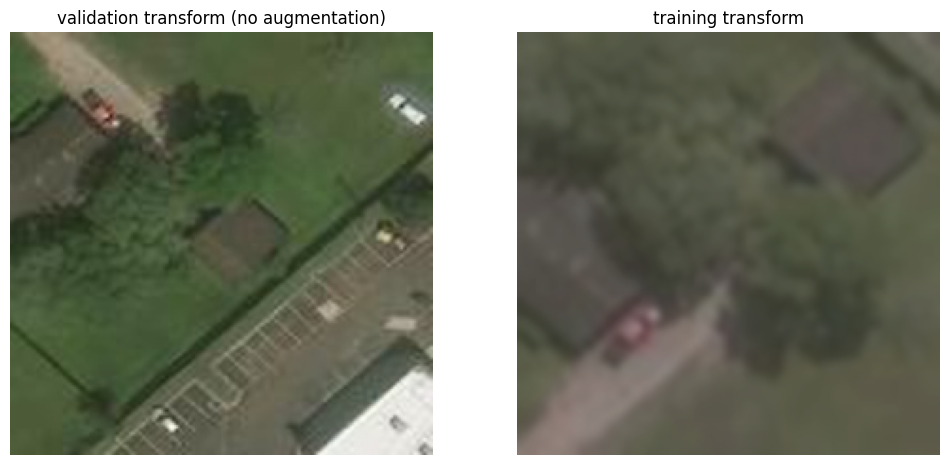

In [30]:
dataset_index = 500

img, label = dataset[dataset_index]

fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(unnormalize(transforms_val(img)).permute(1,2,0))
axs[0].set_title("validation transform (no augmentation)")

axs[1].imshow(unnormalize(transforms_train(img)).permute(1,2,0))
axs[1].set_title("training transform")
[ax.axis("off") for ax in axs] 

I now add the transform function to the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.401592e-07..0.9019612].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.401592e-07..0.5725493].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450746..1.0000005].


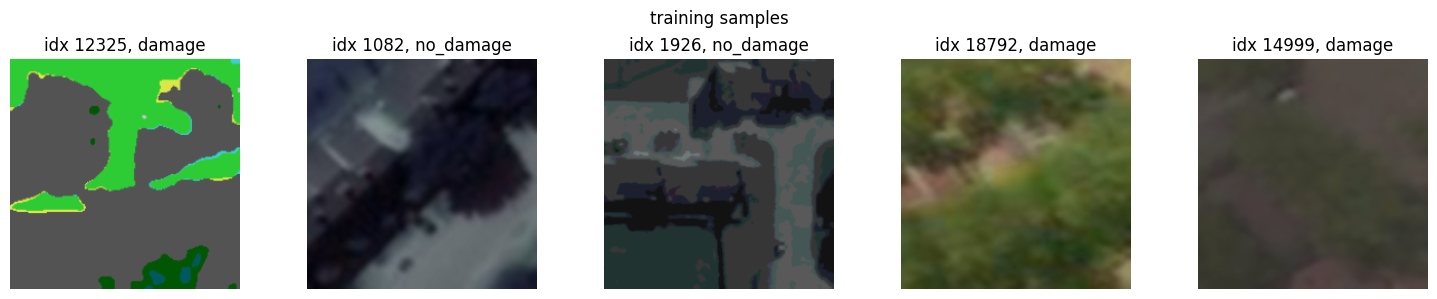

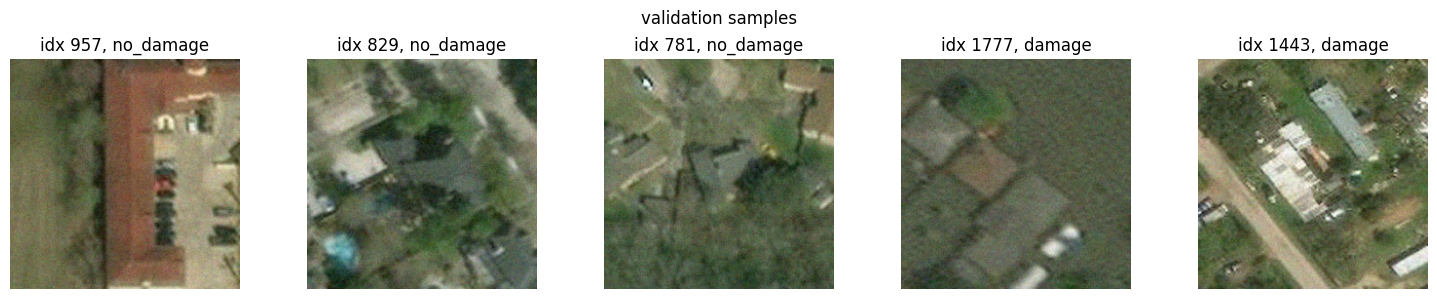

In [ ]:
train_dataset = Hurricane(root_dir="ipeo_hurricane_for_students",  split="train", transforms=transforms_train)
val_dataset = Hurricane(root_dir="ipeo_hurricane_for_students", split= 'validation', transforms=transforms_val)
test_dataset = Hurricane(root_dir="ipeo_hurricane_for_students", split= 'test', transforms=transforms_val)

# Visualization
fig, axs = plt.subplots(1,5, figsize=(5*3, 3))
for ax in axs:
    idx = np.random.randint(len(train_dataset)) # random sample
    image, label = train_dataset[idx]
    ax.imshow(unnormalize(image).permute(1,2,0))
    ax.set_title(f"idx {idx}, {list(Hurricane.LABEL_CLASSES.keys())[label]}")
    ax.axis("off")

fig.suptitle("training samples")
plt.tight_layout()

fig, axs = plt.subplots(1,5, figsize=(5*3, 3))
for ax in axs:
    idx = np.random.randint(len(val_dataset)) # random sample
    image, label = val_dataset[idx]
    ax.imshow(unnormalize(image).permute(1,2,0))
    ax.set_title(f"idx {idx}, {list(Hurricane.LABEL_CLASSES.keys())[label]}")
    ax.axis("off")

fig.suptitle("validation samples")
plt.tight_layout()

In [ ]:
### ----------DataLoader creation---------
### Compute class weights for balanced sampling
train_labels = [label for _, label in train_dataset.data]  # Extract labels from training dataset

class_counts = torch.bincount(torch.tensor(train_labels))               # Count number of samples per class, here [1300, 6000]
class_weights = 1.0 / class_counts                                      # Inverse frequency, here [1/1300, 1/6000]
sample_weights = [class_weights[label] for label in train_labels]       # Assign weight to each sample based on its class

# Test if the weights are correct
# contribution totale par classe
total_weight_class0 = class_weights[0] * class_counts[0]
total_weight_class1 = class_weights[1] * class_counts[1]

total = total_weight_class0 + total_weight_class1

print("Sampling probabilities (true):")
print("damage (0)    →", (total_weight_class0 / total).item())
print("no_damage (1) →", (total_weight_class1 / total).item())

# The train batch are now sampled equally from all classes
# Each bach has the same number of samples from each class on average
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

### 4. Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# DINO Classification Inference

In [ ]:

from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from sklearn.metrics import accuracy_score, f1_score


In [ ]:
BATCH_SIZE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Load Test Dataset
test_img_ds = datasets.ImageFolder(
    test_dataset, transform=Preprocessing_Transforms
)

X_test, y_test = extract_dino_features(
    test_img_ds, CACHE_DIR / "test.pt"
)

test_ds = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


### Download Classifier from pretrained weights

In [ ]:
MODEL_PATH = "Dino/dino_classifier.pth"

classifier.load_state_dict(
    torch.load(MODEL_PATH, map_location=DEVICE)
)
classifier.to(DEVICE)
classifier.eval()

In [ ]:
preds, labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        p = classifier(x).argmax(1).cpu()
        preds.extend(p.numpy())
        labels.extend(y.numpy())

acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average="weighted")

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1: {f1:.4f}")

# LeVit Classification Inference

### Load saved model

In [ ]:
import torch
from transformers import LevitForImageClassification
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LevitForImageClassification.from_pretrained("LeVit/levit_hurricane_damage")
model.to(device)
model.eval()

### Define evaluation function

In [ ]:
def evaluate_accuracy_f1(model, loader):
    all_preds = []
    all_labels = []

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    accuracy = correct / total

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    f1 = f1_score(all_labels.numpy(), all_preds.numpy())

    return accuracy, f1


### Calculate accuracy and F1 score

In [ ]:
val_acc, val_f1 = evaluate_accuracy_f1(model, val_loader)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")


# ResNet Classification Inference

# Calibration

### Initiate temperature scaling module

In [ ]:
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, logits):
        return logits / self.temperature.clamp(min=1e-6)

### Collect logits and labels from validation set

In [ ]:
def collect_logits(model, loader, device):
    model.eval()
    logits_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            logits_list.append(outputs.logits)
            labels_list.append(labels)

    return torch.cat(logits_list), torch.cat(labels_list)


### Fit temperature using validation data

In [ ]:
def fit_temperature(logits, labels, device):
    scaler = TemperatureScaler().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.LBFGS([scaler.temperature], lr=0.01, max_iter=50)

    def closure():
        optimizer.zero_grad()
        loss = criterion(scaler(logits), labels)
        loss.backward()
        return loss

    optimizer.step(closure)
    return scaler


### Expected Calibration Error

In [ ]:
def expected_calibration_error(logits, labels, n_bins=15):
    probs = torch.softmax(logits, dim=1)
    confidences, predictions = probs.max(dim=1)
    accuracies = predictions.eq(labels)

    ece = torch.zeros(1, device=logits.device)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)

    for i in range(n_bins):
        mask = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i + 1])
        if mask.sum() > 0:
            acc = accuracies[mask].float().mean()
            conf = confidences[mask].mean()
            ece += (mask.float().mean()) * torch.abs(acc - conf)

    return ece.item()


### Reliability diagram

In [ ]:
import matplotlib.pyplot as plt

def plot_reliability_diagram(logits, labels, n_bins=15, title="Reliability Diagram"):
    probs = torch.softmax(logits, dim=1)
    confidences, predictions = probs.max(dim=1)
    accuracies = predictions.eq(labels)

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_accs = []
    bin_confs = []

    for i in range(n_bins):
        mask = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i + 1])
        if mask.sum() > 0:
            bin_accs.append(accuracies[mask].float().mean().item())
            bin_confs.append(confidences[mask].mean().item())
        else:
            bin_accs.append(0)
            bin_confs.append(0)

    plt.figure(figsize=(5,5))
    plt.plot([0,1], [0,1], "--", color="gray")
    plt.bar(bin_confs, bin_accs, width=1/n_bins, edgecolor="black")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()


### Full calibration workflow

In [ ]:
# Collect logits
val_logits, val_labels = collect_logits(model, val_loader, device)

# Before calibration
ece_before = expected_calibration_error(val_logits, val_labels)
plot_reliability_diagram(val_logits, val_labels, title="Before Calibration")

# Fit temperature
scaler = fit_temperature(val_logits, val_labels, device)
print("Learned temperature:", scaler.temperature.item())

# After calibration
calibrated_logits = scaler(val_logits)
ece_after = expected_calibration_error(calibrated_logits, val_labels)
plot_reliability_diagram(calibrated_logits, val_labels, title="After Calibration")

print(f"ECE before: {ece_before:.4f}")
print(f"ECE after:  {ece_after:.4f}")


### Save temperature scaler

In [ ]:
torch.save(scaler.state_dict(), "temperature_scaler.pt")